In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
df = pd.read_csv('shop.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["Volume", "Open", "Vix Close", "CRM Close", "TSX Close"])
df

,High,Low,CAD Close,Shop Close
Date,,,,
2015-05-21,35.299999,30.000000,1.22064,31.250000
2015-05-22,38.029999,32.000000,1.21960,34.939999
2015-05-26,37.689999,36.000000,1.23193,36.919998
2015-05-27,38.160000,33.630001,1.24244,34.500000
2015-05-28,34.599998,33.139999,1.24540,34.000000
...,...,...,...,...
2021-01-14,1560.219971,1479.430054,1.26981,1488.680054
2021-01-15,1517.150024,1465.160034,1.26477,1490.949951
2021-01-19,1516.280029,1464.000000,1.27480,1494.390015


In [4]:
df_input = df
df_output = df[["Shop Close"]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [6]:
x_train.shape

(977, 4)

In [7]:
x_test.shape

(419, 4)

In [8]:
x_test

,High,Low,CAD Close,Shop Close
Date,,,,
2019-05-09,352.160004,343.100006,1.34723,350.200012
2019-05-10,351.910004,339.510010,1.34653,347.269989
2019-05-13,340.019989,329.839996,1.34394,337.779999
2019-05-14,342.079987,326.690002,1.34760,340.869995
2019-05-15,356.350006,338.109985,1.34600,355.010010
...,...,...,...,...
2021-01-14,1560.219971,1479.430054,1.26981,1488.680054
2021-01-15,1517.150024,1465.160034,1.26477,1490.949951
2021-01-19,1516.280029,1464.000000,1.27480,1494.390015


In [9]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [10]:
length = 1
batch = 44
features = x_test.shape[1]

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=1, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=1, batch_size=batch)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [12]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17664     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [14]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.00085)

model.compile(optimizer="adam", loss="mean_squared_error")


fit = model.fit_generator(train_generator, epochs = 250, validation_data=test_generator,
                         shuffle=False, callbacks=[earlystop])

Epoch 1/250
23/23 [==============================] - 1s 53ms/step - loss: 0.0984 - val_loss: 0.1637
Epoch 2/250
23/23 [==============================] - 1s 64ms/step - loss: 0.0434 - val_loss: 0.0763
Epoch 3/250
23/23 [==============================] - 1s 50ms/step - loss: 0.0380 - val_loss: 0.0429
Epoch 4/250
23/23 [==============================] - 1s 52ms/step - loss: 0.0291 - val_loss: 0.0204
Epoch 5/250
23/23 [==============================] - 1s 55ms/step - loss: 0.0154 - val_loss: 0.0047
Epoch 6/250
23/23 [==============================] - 1s 49ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 7/250
23/23 [==============================] - 1s 48ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/250
23/23 [==============================] - 1s 57ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 9/250
23/23 [==============================] - 1s 60ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 10/250
23/23 [==============================] - 1s 57ms/step - loss: 0.0038 - val_loss: 0.0021

In [16]:
model.evaluate_generator(test_generator, verbose=0)

0.0008425946616625879

In [17]:
predictions = model.predict_generator(test_generator)

In [18]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

In [24]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks

,Real,Predicted
Date,,
2019-05-10,347.269989,357.894562
2019-05-13,337.779999,356.177460
2019-05-14,340.869995,348.030212
2019-05-15,355.010010,347.984711
2019-05-16,374.489990,359.084167
...,...,...
2021-01-14,1488.680054,1504.234009
2021-01-15,1490.949951,1502.019775
2021-01-19,1494.390015,1483.255981


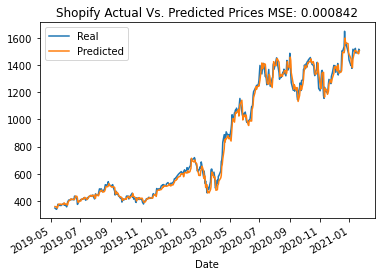

In [25]:
stocks.plot(title=f"Shopify Actual Vs. Predicted Prices MSE: 0.000842")
plt.savefig('ShopifyDay.png')

In [21]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

7.6879879162072084

In [22]:
model_json = model.to_json()
file_path = Path("shop_model_2.json")
with open(file_path, "w") as json_file:
    json_file.write(model_json)